# PROGETTO ANALISI DI IMMAGINI E VIDEO


* **Lorenzo Defina** Matr: 205146 
* **Davide Medaglia** Matr: 207041

Si vuole modellare una rete in grado di classificare 10 tipologie di azioni di giocatori di basket, si utilizzerà un set di  video contenuti nel dataset 'SpaceJam'. La fase di training del modello sarà svolta a valle di un processo di Data Analysis e Data Preparation. Useremo il set di training per addestrare il modello e il set di validation per valutare il modello durante l'addestramento. Nello specifico verrà utilizzata come rete neurale: **ResNet3D** con 18 layers, in quanto questa rete convoluzionale  impiega dei blocchi "residual" e, In particolare, possiede il vantaggio di avere un minor numero di parametri rispetto alla rete C3D impegando quiundi minor tempo per l'addestramento. 

Infine, i risultati saranno valutati per misurare le prestazioni mediante il calcolo di diverse misure quali: Accuratezza; Precision; Recall; F1. 

**p.s.:** in allegato a questo notebook si riporta un ulteriore notebook _"Confronti (Notebook Secondario).ipynb"_ in cui si mostrano i vari test e le valutazioni effettuate.

Questo notebook è strutturato in più sezioni in modo da poter commentare le operazioni svolte.

## Indice:


1.   **Get the data**
2.   **Data Analysis**
*   **Data Preparation**
*   **Pre Processing**
*   **Comparison**
* **Data Loading**
*   **Action Recognitioin**
* **Model Evaluation**
*   **Conclusions**






## **1. GET THE DATA**


Si importano le librerie necessarie:

In [1]:
SEED = 9126

import os
import json
import time
from datetime import datetime
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import DatasetFolder
from torchvision import transforms, datasets, models
import torchvision
from torchvision import datasets
import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, precision_score, accuracy_score
from sklearn.model_selection import train_test_split
import cv2
from glob import glob
import shutil
import timeit
from datetime import datetime
from tqdm import tqdm
from PIL import Image
import gc
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

USE_CUDA = True
CUDA = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
if CUDA:
    print('run on %s' % device)
    

PyTorch Version:  1.5.1
Torchvision Version:  0.6.1
run on cuda


In [2]:
KEYSET_FILE ='./testset_keys_1lug2020.txt'
labels_dict = {0 : "block", 1 : "pass", 2 : "run", 3: "dribble",4: "shoot",
          5 : "ball in hand", 6 : "defense", 7: "pick" , 8 : "no_action" , 
          9: "walk" ,10: "discard"}

with open(os.path.join('.', 'annotation_dict.json')) as fp:  
    annotations = json.load(fp)    
print('N° di video totali: ',len(annotations))

N° di video totali:  37085


In [3]:
with open(KEYSET_FILE) as fp:
    keys_test = json.load(fp)

annotationTraining = dict(filter(lambda x: x[0] not in keys_test, annotations.items()))
annotationTest = dict(filter(lambda x: x[0] in keys_test, annotations.items()))

len(annotations), len(annotationTraining), len(annotationTest)

(37085, 25959, 11126)

## 2. Data Analysis
Si vuole mostrare il numero e la distribuzione dei video tra le differenti classi.

_**Osservazione:**_ non è stato considerata la label 'discar' in quanto non sono stati trovati video appartenenti a questa classe 

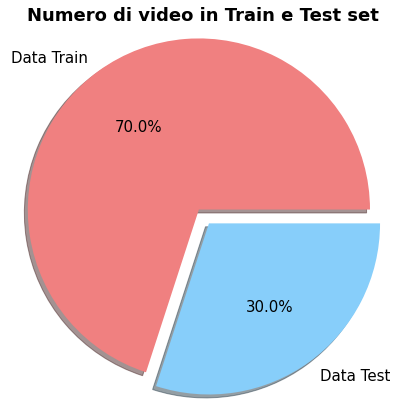

In [4]:
plt.rcParams.update({'font.size': 15})
labels = ['Data Train', 'Data Test']
sizes = [len(annotationTraining), len(annotationTest)]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  
plt.figure(figsize=(7,7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True)
plt.title('Numero di video in Train e Test set', fontsize=18, fontweight="bold")
plt.axis('equal')
plt.show()

In [5]:
def bar_chart(annotation, cartella):
    plt.rcParams.update({'font.size': 13})
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd','#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    plt.figure(figsize=(13,6))
    a = np.array(list(annotation.values()))
    unique, counts = np.unique(a, return_counts=True)
    bars = plt.bar(unique, counts, align='center', alpha=0.8, color=colors)
    index = list(labels_dict.values())
    plt.xticks(unique, index)
    for bar, val in zip(bars, counts):
        plt.text(bar.get_x()+0.2, +bar.get_height(), val)
    plt.title("Distribuzione dei video in "+cartella, fontsize=20,fontweight="bold")
    plt.show()

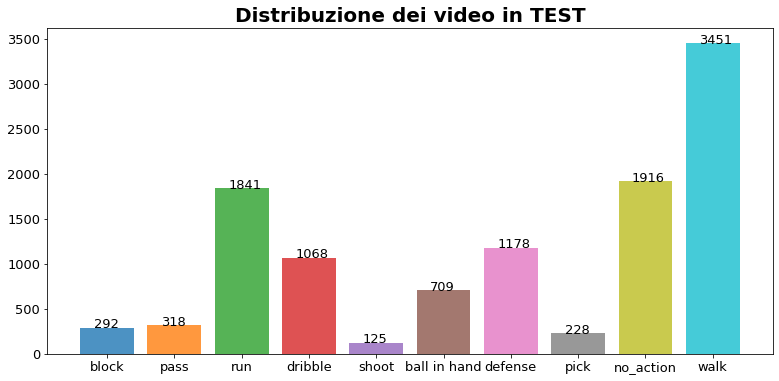

In [6]:
bar_chart(annotationTest, 'TEST')

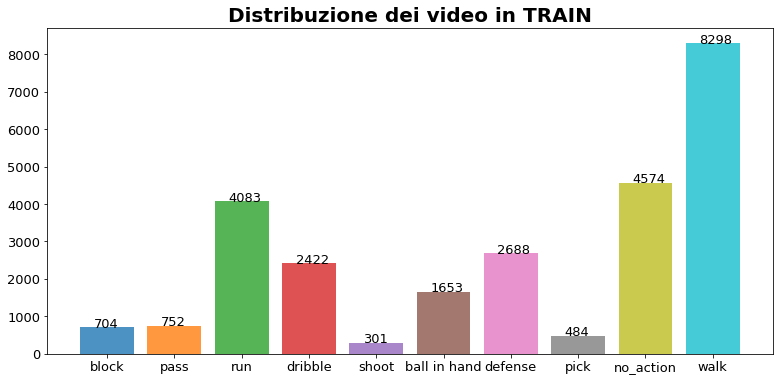

In [7]:
bar_chart(annotationTraining, 'TRAIN')

Il partizionamento totale del dataset è formato:
* 70% di Training
* 30% di Test

Inoltre graficanndo l'attributo 'label' del dataset in questione si è reso noto che all'interno di 'Video Train', si hanno i seguenti risultati:
*  **Classe 0 :** N° 704
*  **Classe 1 :** N° 752
*  **Classe 2 :** N° 4083
*  **Classe 3 :** N° 2422
*  **Classe 4 :** N° 301
*  **Classe 5 :** N° 1653
*  **Classe 6 :** N° 2688
*  **Classe 7 :** N° 484
*  **Classe 8 :** N° 4574
*  **Classe 9 :** N° 8298

## 3. DATA PREPARATION

Dal set di training viene creato un Validation set, è opportuno assicurare che la distribuzione di video in ogni classe sia simile sia nel set di training che in quello di validation. Questo viene garantito utilizzando il parametro 'stratify'.

Inoltre, in 'Video Validation' si ha lo stesso numero di video presenti nella cartella 'Video Test'. 

In [8]:
train_x, valid_x, label_train, label_valid = train_test_split(list(annotationTraining.keys()), list(annotationTraining.values()),
                                                     test_size=len(annotationTest), random_state=SEED, stratify=list(annotationTraining.values()))
print('Dimensioni training set: ',len(train_x), len(label_train))
print('Dimensioni validation set: ',len(valid_x), len(label_valid))

annotationTrain = dict(zip(train_x, label_train))
annotationValid = dict(zip(valid_x, label_valid))

Dimensioni training set:  14833 14833
Dimensioni validation set:  11126 11126



Il dataset sarà opportunamente manipolato ai fini dell'analisi per cui è necessario eseguire una prima suddivisone in  cartelle: 

*   **Video Train :** video relativi al Training set
*   **Video Test :** video relativi al Test set
*   **Video Validation :** video relativi al Validation set
*   **file.npy :** conterrà ifile di formato .npy, essi corrispondono a dei vettori che esprimono la posizione degli arti dei giocatori 


Per comodità viene creata una suddivisione all'interno delle cartelle: 'Video Train', 'Video Test' e 'Video Validation' in 10 sotto cartelle con la funzione 'create_class_separation'. Ogni sotto cartella racchiude tutti i video con la stessa label (ovvero stessa azione di basket) e questo viene raggiunto con la funzione 'class_separation'.

In [ ]:
# funzione per separare i video nelle cartelle train, test, validation e i file npy

def file_separation(FOLDER):
    name_folder = ['Video Train', 'Video Test', 'Video Validation', 'Video avanzati', 'file.npy']
    for name in name_folder:
        if not os.path.isdir(os.path.join(FOLDER, name)):
            os.mkdir(os.path.join(FOLDER, name))
    train=0
    test=0
    valid=0
    niente=0
    for root, dirs, files in os.walk(FOLDER):
        for name in files:
            DIR_SRC = os.path.join(FOLDER, name)
            vname = name.replace('.mp4', '') # elimino estensione nome
            if name.endswith('.npy'):
                DIR_DST = os.path.join(FOLDER, 'file.npy')
                shutil.move(DIR_SRC, DIR_DST)
            
            elif vname in annotationTrain:
                DIR_DST = os.path.join(FOLDER, 'Video Train')
                shutil.move(DIR_SRC, DIR_DST)
                train += 1
            
            elif vname in annotationTest:
                DIR_DST = os.path.join(FOLDER, 'Video Test')
                shutil.move(DIR_SRC, DIR_DST)
                test += 1
            
            elif vname in annotationValid:
                DIR_DST = os.path.join(FOLDER, 'Video Validation')
                shutil.move(DIR_SRC, DIR_DST)
                valid += 1
            
            else:
                DIR_DST = os.path.join(FOLDER, 'Video avanzati')
                shutil.move(DIR_SRC, DIR_DST)
                niente += 1
    print('N° test {} - N° train {} - N° validation {} - N° avanzati {}'.format(test, train, valid, niente))
    print('DONE')

FOLDER = '.\examples'
file_separation(FOLDER)

In [ ]:
# questa funzione crea le cartelle per le classi da 0 a 9

def create_dir_separation(DIR_SOURCE, numClass=10):
    for i in range(numClass):
        DIR_CLASS = os.path.join(DIR_SOURCE,'classe'+str(i))
        if not os.path.isdir(DIR_CLASS):
            os.mkdir(os.path.join(DIR_SOURCE,'classe'+str(i)))
            print('Creata classe {} esito: {}'.format(i, os.path.isdir(DIR_CLASS)))
    print('DONE')
        
# questa funzione sposta i video nelle cartelle delle classi
def class_separation(DIR_SOURCE, annotation):
    nameVideo = [f for f in os.listdir(DIR_SOURCE) if f.endswith('.mp4')]
    print(len(nameVideo))
    
    for name in nameVideo:
        nvideo = name.replace('.mp4','')
        classe = annotation[nvideo]
        FOLDER_SRC = os.path.join(DIR_SOURCE, name)
        FOLDER_DST = os.path.join(DIR_SOURCE,'classe'+str(classe))
        shutil.move(FOLDER_SRC, FOLDER_DST)
    
    print('DONE')


Inizamo prima dalla cartella 'Video Train':

In [ ]:
# separiamo i video del train in classi

now = time.time()
DIR_SOURCE = './examples/Video Train'
create_dir_separation(DIR_SOURCE)
print('-'*30)
class_separation(DIR_SOURCE, annotationTrain)      
print(time.time()-now)
print('DONE')


Passiamo alla cartella 'Video Test':

In [ ]:
# separiamo i video del test in classi

now = time.time()
DIR_SOURCE = './examples/Video Test'
create_dir_separation(DIR_SOURCE)
print('-'*30)
class_separation(DIR_SOURCE, annotationTest)      
print(time.time()-now)
print('DONE')


E infine la cartella 'Video Validation':

In [ ]:
# separiamo i video del Validation in classi

now = time.time()
DIR_SOURCE = './examples/Video Validation'
create_dir_separation(DIR_SOURCE)
print('-'*30)
class_separation(DIR_SOURCE, annotationValid)      
print(time.time()-now)
print('DONE')


# 4. Pre Processing

Non è stata effettuata data augmentation sui video in quanto il dataset presenta già dei video ruotati verticalemnte.

# 5. Comparison

In questa sezione si riportano i parametri e le scelte progettuali effettuate nel notebook "Confronti.ipynb" allegato a questo notebook.

* **tipo di rete ResNet3D pre-addestrata**: usare una rete preaddestrata su un altro dataset aiuta a generalizzare maggiormente i dati, i pesi utilizzati si basano sul dataset _Kinetics-400_
* **optimazer ADAM**: questo ottimizzatore è risultato essere più efficiente rispetto a SGD
* **funzione di loss**: CROSS ENTROPY non pesata
* **learning rate iniziale**: 1e-3
* **scheduler**: ReduceLROnPlateau(patience=5, factor=0.1)
* **batch size**: 16, la dimensione del batch è stata scelta in relazione alla massima disponibilità di memoria della GPU usata per l'addestramento

# 6. Data Loading

* **VideoFolder**: è la classe incaricata di caricare i video e le label a partire dalla suddivisione in cartelle su file
* **VideoDataset**: è la classe incaricata di estrarre i frame dai video, assegnare le corrispondenti label e applicare trasformazioni in pipeline sui frames includendo una resize per ogni frame 112x112 (dimensioni dell'input della rete), trasformazione in tensore e normalizzazione tramite media e varianza
* **DataLoader**: è la classe incaricata di creare i batch da usare durante la fase di training del modello

In [5]:
VIDEO_EXTENSION = '.mp4'
    
def video_loader(path):
    with open(path, 'rb') as f:
        video  = cv2.VideoCapture(path)
        return video

class VideoFolder(DatasetFolder):
    '''
    input:
        root = path della cartella dei file
    '''
    def __init__(self, root, transform=None, target_transform=None, loader=video_loader, is_valid_file=None):
        super(VideoFolder, self).__init__(root, loader, VIDEO_EXTENSION if is_valid_file is None else None,
                                          transform=transform,
                                          target_transform=None,
                                          is_valid_file=is_valid_file)
        self.video = self.samples

In [6]:
train = VideoFolder(root='./examples/Video Train')
valid = VideoFolder(root='./examples/Video Validation')

print('Dimensioni training: ', len(train))
print('Dimensioni validation: ', len(valid))

Dimensioni training:  14833
Dimensioni validation:  11126


In [7]:
class VideoDataset(Dataset):
    '''
    input:
        data = dizionario con video e label
        trasform =  trasformazione da applicare a tutti i 16 frame di un video
    '''
    def __init__(self, data, transform):
        self.transform = transform 
        self.data = data
        
    def __len__(self):
        return (len(self.data))
    
    def __getitem__(self, index):
        video, label = self.data[index]
        frames_sequence = []
        
        while True:
            ret, frame = video.read()
            if ret != True:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)
            frame = self.transform(frame)
            frames_sequence.append(frame)
        
        frames_sequence = torch.stack(frames_sequence)
        frames_sequence = torch.transpose(frames_sequence, 1, 0)
        
        return frames_sequence, label

In [8]:
transformer = transforms.Compose([transforms.Resize((112,112)), transforms.ToTensor()])

train_data = VideoDataset(data=train, transform=transformer)
valid_data = VideoDataset(data=valid, transform=transformer)

print('Dimensioni training: ', len(train_data))
print('Dimensioni validation: ', len(valid_data))

Dimensioni training:  14833
Dimensioni validation:  11126


In [18]:
imgs, label = train_data[0]
print(imgs.shape)
print('-'*30)

imgs, label = valid_data[0]
print(imgs.shape)

torch.Size([3, 16, 112, 112])
------------------------------
torch.Size([3, 16, 112, 112])


In [9]:
batch_size = 16

trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
validloader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

print('BATCH_SIZE: ', batch_size)
print('Dimensioni train loader: ', len(trainloader))
print('Dimensioni valid loader: ', len(validloader))

BATCH_SIZE:  16
Dimensioni train loader:  928
Dimensioni valid loader:  696


In [10]:
trainiter = iter(trainloader)
images, labels = next(trainiter)
print(images.shape, labels.shape)

torch.Size([16, 3, 16, 112, 112]) torch.Size([16])


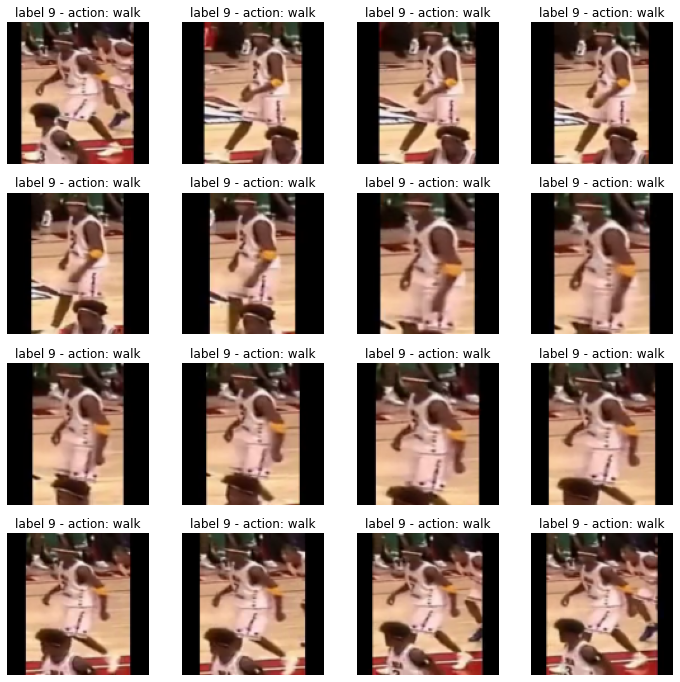

In [12]:
def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    return x

plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4,4, i+1)
    image = images[0,:, i-1].numpy().transpose(1, 2, 0)
    plt.imshow(image)
    plt.title('label {} - action: {}'.format(int(labels[0]), labels_dict[int(labels[0])]))
    plt.axis('off')
plt.show()

# 7. Action Recognition
### Funzioni di train e validation

Per valutare la bontà dei risultati del sistema in questione è opportuno servirsi delle metriche che calcolano quanto la risposta del sistema sia lontana o vicina dalla risposta corretta.
Le metriche da noi utilizzate sono le seguenti:

* **loss function**: funzione di costo che valuta le prestezioni del modello. Minore è la loss, migliore sarà il modello.</li>
* **accurancy**: calcola quanti esempi venogno classificati correttamente. 

L'obiettivo della fase di addestramento del modello è la "convergenza" della <b>loss</b> e dell'<b> accurancy</b>. Difatti, ad ogni epoch la loss deve decresce tendendo asintoticamente a un valore minimo. Analogo opposto vale per l'accuratezza.

In [33]:
def accuracys_batch(target, output):    
    # obtain output class    
    pred = output.argmax(dim=1, keepdim=True)    
    # compare output class with target class    
    corrects = pred.eq(target.view_as(pred)).sum().item()    
    return corrects 

def loss_epoch(model, loss_func, dataset_dl, opt=None):    
    lossTot = 0.0   
    accuracy = 0.0
    acc_batch = []
    loss_batch = []
    
    for inputs, labels in tqdm(dataset_dl):        
        # data to cuda
        inputs = Variable(inputs.to(device), requires_grad=True)       
        labels = Variable(labels.to(device), requires_grad=False)       
        # obtain model output        
        predict = model(inputs)
        # obtain loss    
        loss = loss_func(predict, labels) 
        loss_b = loss.item()
        # obtain performance accuracy
        accuracy_b = accuracys_batch(labels, predict)
        if opt is not None: # only training
            loss.backward()        
            opt.step()        
            opt.zero_grad()
        
        # stat
        loss_batch.append(loss_b)
        lossTot+=loss_b
        acc_batch.append(accuracy_b/batch_size * 100)
        if accuracy_b is not None:            
            accuracy+=accuracy_b
    
    lossTot /= len(dataset_dl)     
    accuracy /= len(dataset_dl.dataset)
    
    return lossTot, accuracy, acc_batch, loss_batch

In [23]:
def training(epochs, model, loss_func, opt, scheduler, train_dl, val_dl):
    stat = pd.DataFrame(columns=['epoch',  'train loss', 'loss batch', 'train acc', 'acc bath'])
    start_time = timeit.default_timer()
    #model.to(device)
    loss_func.to(device)
    for epoch in range(epochs):        
        model.train()      
        
        train_loss, train_metric, acc_batch, loss_batch = loss_epoch(model,loss_func,train_dl,opt)
        
        train_accuracy = train_metric*100
        print('TRAIN - Epoca[{}/{}] - train loss: {:.6f} ({:.6f}) train accuracy: {:.2f}'.format(epoch+1, epochs, 
                                                                                                   train_loss, 
                                                                                                   np.array(loss_batch).mean(),
                                                                                                   train_accuracy))
        stop_time = timeit.default_timer()
        print("Execution time: " + str(stop_time - start_time) + "\n")
        stat = stat.append({'epoch':epoch, 'train loss':train_loss, 'loss batch':loss_batch, 
                            'train acc':train_accuracy, 'acc bath':acc_batch}, ignore_index=True)
        
        # salvo modello e parametri
        save_model(epoch, model, opt, loss_func, scheduler, stat, 'ResNet3D')
        
        # validation
        val_loss = validation(epoch, model, loss_func, val_dl)
        
        # aggiusto learning rate
        scheduler.step(val_loss)
        
        # Empty cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            
    return model

def save_model(epoch, model, opt, loss_func, scheduler, stat, name_model, save_dir='./save'):
    if not os.path.isdir(save_dir):
            os.mkdir(save_dir)
    torch.save({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'opt_dict': opt.state_dict(),
        'loss_dict': loss_func.state_dict(),
        'sheduler_dict': scheduler.state_dict()
    }, os.path.join(save_dir, name_model+'_epoch-' + str(epoch) + '.pth'))
    
    stat.to_csv(os.path.join(save_dir, name_model+'_train_epoch-' + str(epoch) + '.csv'))
    print("Save model at {}".format(os.path.join(save_dir, name_model+'_epoch-' + str(epoch) + '.pth')))
        
def validation(epoch, model, loss_func, val_dl, save_dir='./save'):
    stat = pd.DataFrame(columns=['epoch',  'valid loss', 'loss batch', 'valid acc', 'acc bath'])
    start_time = timeit.default_timer()
    #model.to(device)
    #loss_func.to(device)
    model.eval()        
    
    with torch.no_grad():            
        val_loss, val_metric, acc_batch, loss_batch = loss_epoch(model, loss_func, val_dl)        
        val_accuracy=100*val_metric

    print("VALIDATION - Epoca {} - val loss: {:.6f} ({:.6f}), val accuracy: {:.2f} ({:.2f})".format(epoch, 
                            val_loss, np.array(loss_batch).mean(), val_accuracy, np.array(acc_batch).mean()) )
        
    stat = stat.append({'epoch':epoch, 'valid loss':val_loss, 'loss batch':loss_batch, 
                                'valid acc':val_accuracy, 'acc bath':acc_batch}, ignore_index=True)
    stop_time = timeit.default_timer()
    print("Execution time: " + str(stop_time - start_time) + "\n")
        
    
    stat.to_csv(os.path.join(save_dir, 'ResNet3D_valid_epoch-' + str(epoch) + '.csv'))
    return val_loss


### Modello di rete ResNet3D

In [20]:
class BasicStem(nn.Sequential):
    """The default conv-batchnorm-relu stem
    """
    def __init__(self):
        super(BasicStem, self).__init__(
            nn.Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True))

class Conv3DSimple(nn.Conv3d):
    def __init__(self,
                 in_planes,
                 out_planes,
                 midplanes=None,
                 stride=1,
                 padding=1):

        super(Conv3DSimple, self).__init__(
            in_channels=in_planes,
            out_channels=out_planes,
            kernel_size=(3, 3, 3),
            stride=stride,
            padding=padding,
            bias=False)

    def get_downsample_stride(stride):
        return (stride, stride, stride)


class BasicBlock(nn.Module):

    expansion = 1

    def __init__(self, inplanes, planes, conv_builder, stride=1, downsample=None):
        midplanes = (inplanes * planes * 3 * 3 * 3) // (inplanes * 3 * 3 + 3 * planes)

        super(BasicBlock, self).__init__()
        self.conv1 = nn.Sequential(
            conv_builder(inplanes, planes, midplanes, stride),
            nn.BatchNorm3d(planes),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            conv_builder(planes, planes, midplanes),
            nn.BatchNorm3d(planes)
        )
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class VideoResNet(nn.Module):

    def __init__(self, num_classes, block, conv_makers, layers, stem):
        '''
        Args:
            num_classes (int): dimensioni di output del layer fully-connected
            block (nn.Module): resnet building block
            conv_makers (list(functions)): generatore di funzione per ogni layer
            layers (List[int]): numeri di block per ogni layer
            stem (nn.Module, optional): Resnet stem, if None, defaults to conv-bn-relu. Defaults to None.
            
        '''
        super(VideoResNet, self).__init__()
        self.inplanes = 64

        self.stem = stem()

        self.layer1 = self._make_layer(block, conv_makers[0], 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, conv_makers[1], 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, conv_makers[2], 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, conv_makers[3], 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
    
       
    def forward(self, x):
        x = self.stem(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        # Flatten the layer to fc
        x = x.flatten(1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, conv_builder, planes, blocks, stride=1):
        downsample = None

        if stride != 1 or self.inplanes != planes * block.expansion:
            ds_stride = conv_builder.get_downsample_stride(stride)
            downsample = nn.Sequential(nn.Conv3d(self.inplanes, planes * block.expansion, 
                                                 kernel_size=1, stride=ds_stride, bias=False),
                                                nn.BatchNorm3d(planes * block.expansion))
        layers = []
        layers.append(block(self.inplanes, planes, conv_builder, stride, downsample))

        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, conv_builder))

        return nn.Sequential(*layers)

def ResNet3D(num_classes):
    return VideoResNet(num_classes, block=BasicBlock, conv_makers=[Conv3DSimple] * 4, layers=[2, 2, 2, 2], stem=BasicStem)

### Strategia Transfer Learning

Per utilizzare un modello pre-addestrato si segue questo protocollo:

- Si carica il modello pre-addestrato
- Si mantengono fissi i pesi dei layer convoluzionali
- Si sostituiscono i layer fully connected e si procede con l'addestramento sul dataset di interesse

Si utilizzano i pesi di ResNet3D preaddestrata sul dataset **Kinetics-400**

In [12]:
# i pesi sono compatibili con un numero di classe di output di 400
model_r3d = ResNet3D(num_classes=400)
model_r3d.load_state_dict(torch.load('./r3d_18-preaddestrata.pth', map_location='cpu'))

# Freeze layer
# Per impedire l'aggiornamento dei pesi del modello escludiamo i relativi tensori dal grafo di computazione
for param in model_r3d.parameters():
    param.requires_grad = False

### Nuovo layer fully connected

Si aggiungono i layer per la classificazione e si sostituisce l'ultimo livello con un livello linerae "fully connected" nel seguente modo:

- La dimensione dell'input deve essere uguale all'output del layer precedente
- La dimensione dell'output (ultimo livello) deve essere pari al numero di classi (10 per il dataset utilizzato in questo notebook)

In [ ]:
n_inputs = model_r3d.fc.in_features
model_r3d.fc = nn.Linear(n_inputs, 10, bias=True)
model_r3d

In [14]:
model_r3d.to(device)

# Learning rate
lr=1e-3 

# funzione di loss
criterion = nn.CrossEntropyLoss()   

# ottimizzatore
optimizer = optim.Adam(model_r3d.parameters(), lr=lr)

# lo scheduler il learning rate per 0.1 ogni 5 epoche
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, min_lr=1e-6) 

num_epochs=10

In [ ]:
model_r3d_trained = training(num_epochs, model=model_r3d, loss_func=criterion, opt=optimizer, scheduler=scheduler, train_dl=trainloader , val_dl=validloader)

## Risultati dell'addestramento della rete

### Test set

In [23]:
test = VideoFolder(root='./examples/Video Test')
test_data = VideoDataset(data=test, transform=transformer)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [24]:
trainiter = iter(testloader)
features, labels = next(trainiter)
print(features.shape, labels.shape)
print('Dimensioni del test loader: ',  len(testloader))


torch.Size([16, 3, 16, 112, 112]) torch.Size([16])
Dimensioni del test loader:  696


Per poter usare il modello addestrato ricorrere alla funzione _"load_model()"_

In [38]:
def test(model, loss_func, test_dl):
    start_time = timeit.default_timer()
    model.to(device)
    loss_func.to(device)
    model.eval()        
    
    with torch.no_grad():            
        test_loss, test_metric, test_batch, test_batch = loss_epoch(model, loss_func, test_dl)        
        test_accuracy=100*test_metric

    print("TEST - loss: {:.6f}, accuracy: {:.2f} )".format(test_loss, test_accuracy))
        
    stop_time = timeit.default_timer()
    print("Execution time: " + str(stop_time - start_time) + "\n")

In [39]:
test(model_r3d_trained, nn.CrossEntropyLoss(), testloader)

100%|██████████| 696/696 [07:50<00:00,  1.48it/s]

TEST - loss: 0.804842, accuracy: 77.07 )
Execution time: 470.35295240000005



### Training e Validation set

In [15]:
train = pd.read_csv('./train.csv')
train

,epoch,train loss,loss batch,train acc,acc bath
0,0,1.562625,"[2.2273623943328857, 2.254241466522217, 2.2876...",45.495285,"[12.5, 6.25, 25.0, 25.0, 18.75, 6.25, 18.75, 3..."
1,1,1.357042,"[1.2279791831970215, 1.3652498722076416, 1.556...",53.133570,"[50.0, 50.0, 43.75, 56.25, 68.75, 62.5, 56.25,..."
2,2,1.305878,"[1.1290626525878906, 1.5061782598495483, 1.058...",54.324125,"[56.25, 43.75, 75.0, 43.75, 75.0, 43.75, 62.5,..."
3,3,1.267514,"[1.0735139846801758, 1.4135417938232422, 1.227...",55.661829,"[62.5, 50.0, 56.25, 50.0, 62.5, 50.0, 50.0, 37..."
4,4,0.963483,"[1.0311932563781738, 1.179016351699829, 1.2950...",65.922088,"[75.0, 56.25, 50.0, 62.5, 43.75, 50.0, 56.25, ..."
5,5,0.550629,"[0.5866655707359314, 1.0033003091812134, 0.537...",81.141089,"[87.5, 62.5, 81.25, 87.5, 68.75, 87.5, 68.75, ..."
6,6,0.303282,"[0.26970556378364563, 0.39033371210098267, 0.1...",90.062571,"[93.75, 87.5, 100.0, 100.0, 75.0, 93.75, 100.0..."
7,7,0.133406,"[0.22605660557746887, 0.1642826944589615, 0.12...",96.454282,"[81.25, 100.0, 100.0, 100.0, 93.75, 87.5, 100...."
8,8,0.068080,"[0.030855774879455566, 0.0315740704536438, 0.0...",98.553455,"[100.0, 100.0, 100.0, 100.0, 93.75, 93.75, 100..."


In [16]:
valid = pd.read_csv('./valid.csv')
valid

,epoch,valid loss,loss batch,valid acc,acc bath
0,0,1.342264,"[2.1805624961853027, 1.9810110330581665, 2.335...",53.241739,"[12.5, 12.5, 12.5, 18.75, 31.25, 12.5, 0.0, 0...."
1,1,1.274316,"[1.7329609394073486, 1.4893264770507812, 1.895...",56.546336,"[50.0, 43.75, 43.75, 50.0, 81.25, 43.75, 12.5,..."
2,2,1.235826,"[2.286379814147949, 1.9082647562026978, 2.3666...",56.887572,"[18.75, 31.25, 18.75, 37.5, 75.0, 37.5, 6.25, ..."
3,3,1.210700,"[2.3661179542541504, 1.8962005376815796, 2.380...",57.282687,"[18.75, 31.25, 18.75, 43.75, 62.5, 37.5, 12.5,..."
4,5,0.817037,"[2.3330793380737305, 1.453302264213562, 0.6360...",76.595362,"[43.75, 56.25, 81.25, 81.25, 81.25, 87.5, 43.7..."
5,4,0.753758,"[1.9910608530044556, 1.2213462591171265, 0.993...",73.539457,"[56.25, 75.0, 56.25, 87.5, 75.0, 56.25, 43.75,..."
6,6,0.783244,"[2.5977916717529297, 1.3611507415771484, 0.612...",76.172928,"[37.5, 56.25, 87.5, 75.0, 75.0, 87.5, 31.25, 6..."
7,7,0.739958,"[1.69214928150177, 1.060023546218872, 0.668321...",75.337048,"[62.5, 62.5, 68.75, 81.25, 81.25, 93.75, 43.75..."
8,8,0.696652,"[1.845680832862854, 1.27278733253479, 0.757891...",75.597699,"[43.75, 62.5, 62.5, 81.25, 81.25, 87.5, 43.75,..."


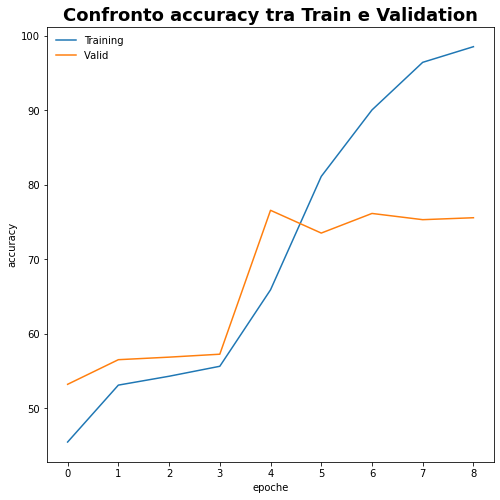

In [8]:
plt.figure(figsize=(8, 8))
plt.title('Confronto accuracy tra Train e Validation', fontsize=18, fontweight="bold")
plt.plot(train['epoch'], train['train acc'], label='Training ')
plt.plot(train['epoch'], valid['valid acc'], label='Valid ')
plt.xlabel('epoche')
plt.ylabel('accuracy')
plt.legend(frameon=False)
plt.show();

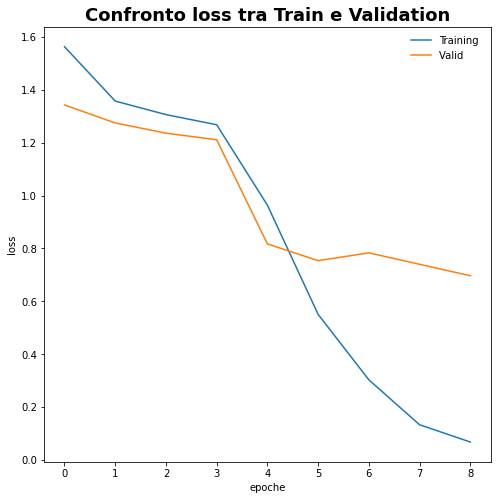

In [9]:
plt.figure(figsize=(8, 8))
plt.title('Confronto loss tra Train e Validation', fontsize=18, fontweight="bold")
plt.plot(train['epoch'], train['train loss'], label='Training ')
plt.plot(train['epoch'], valid['valid loss'], label='Valid ')
plt.xlabel('epoche')
plt.ylabel('loss')
plt.legend(frameon=False)
plt.show();

# 8. Model Evaluation: Test Suite
Vengono valutate le prestazioni del modello sul Test Set.

Per poter eseguire correttamente questa sezione bisogna aver eseguito le sezioni: _Get Data_ , _Data Preparation_ , _Data Loading_ .

In [17]:
test = VideoFolder(root='./examples/Video Test')
test_data = VideoDataset(data=test, transform=transformer)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [18]:
trainiter = iter(testloader)
features, labels = next(trainiter)
print(features.shape, labels.shape)
print('Dimensioni del test loader: ',  len(testloader))


torch.Size([16, 3, 16, 112, 112]) torch.Size([16])
Dimensioni del test loader:  696


In [21]:
def load_model(path='./ResNet3D.pth'):
    checkpoint = torch.load(path, map_location='cpu')
    model_r3d = ResNet3D(num_classes=10)
    model_r3d.load_state_dict(checkpoint['state_dict'])
    return model_r3d

model = load_model()

In [22]:
def classify(model, testloader):
    y_pred_list = []
    y_true_list = []
    model.to(device)
    with torch.no_grad():
        model.eval()
        for X_batch, Y_batch in tqdm(testloader):
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
            _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
            y_pred_list.append(y_pred_tags.cpu().numpy())
            y_true_list.append(Y_batch.numpy())

    flatten = lambda l: [item for sublist in l for item in sublist]
    y_true = flatten(y_true_list)
    y_pred = flatten(y_pred_list)
    
    
    return y_true, y_pred

y_true, y_pred = classify(model, testloader)
report = classification_report(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: ', accuracy)
print('Precision media: ', precision)
print(report)

100%|██████████| 696/696 [07:58<00:00,  1.45it/s]

Accuracy:  0.7707172388998742
Precision media:  0.7609553354083874
              precision    recall  f1-score   support

           0       0.78      0.71      0.74       292
           1       0.62      0.47      0.54       318
           2       0.84      0.81      0.82      1841
           3       0.88      0.90      0.89      1068
           4       0.82      0.64      0.72       125
           5       0.78      0.73      0.76       709
           6       0.74      0.67      0.71      1178
           7       0.65      0.46      0.54       228
           8       0.76      0.75      0.75      1916
           9       0.73      0.82      0.77      3451

    accuracy                           0.77     11126
   macro avg       0.76      0.70      0.72     11126
weighted avg       0.77      0.77      0.77     11126



# 9. Conclusion

All'inizio dell'elaborato, dopo aver acquisito il Dataset, per prendere familiarità con i video che componevano il medesimo sono state svolte alcune analisi. In seguito, oltre a vari confronti affrontati in precedenza ci siamo cimentati su una seconda rete: <b> C3D.</b> Facendo un rapido confronto con la rete <b>ResNet3D</b> siamo arrivati a conclsuione che quest'ultima permettesse di ottenere risultati e prestazioni migliori.
Infatti alla luce dei risultati ottenuti, si sono registrati i seguenti valori: 
<ul>
<li><b>Accuracy:</b> 70.1 %</li>
    <li><b>Precision:</b> 76.1 %</li>
